You are the lead Data Scientist for Pharmaceutical company Kipla, they have collected comments for various products scraping from various online sources and wish to create a sentiment analysis engine that can track the sentiment regarding a specified drug from 3 categories namely positive negative and neutral. Every sample will contain the text mentioning a drug name and the comment pertaining to it. Multiple products could be there within a single comment



Example

I looked up stomach pain after taking Correctol...and here I am, wishing I had read these comments before I took it. I'm sitting here with the worst stomach pain I've had since labor. I feel like I need to vomit but have dry mouth. My intestines feel like someone is twisting them.ive honestly been sitting on the toilet for an hour and no bm...just severe abdominal pain and I vomited once. I will NEVER take this medication again! Post that I took Meftal Spas and it worked wonders for me.



Now this comment is positive for Meftal Spas medicine but negative for Correctol.

Evaluation Metric
The metric used for evaluating the performance of the classification model would be macro F1-Score.  



In [ ]:
#import torch library
import torch

# check GPU availability
if torch.cuda.is_available():
    # select GPU
    device = torch.device("cuda")
else: # If no GPU is available, use CPU
    device = torch.device("cpu")

device

device(type='cuda')

In [ ]:
# check GPU name
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
from transformers import BertModel

# Load BERT-base-uncased
bert = BertModel.from_pretrained('bert-base-uncased')


In [ ]:
# print bert architecture
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
#Download BERT Tokenizer
#importing fast "BERT" tokenizer
from transformers import BertTokenizerFast

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
text = 'Jim is a waiter'
sent_id = tokenizer.encode(text,
                           # add [CLS] and [SEP] tokens
                           add_special_tokens=True,
                           # specify maximum length for the sequences
                           max_length = 10,
                           truncation = True,
                           # add pad tokens to the right side of the sequence
                           pad_to_max_length='right')

# print integer sequence
print("Integer Sequence: {}".format(sent_id))

Integer Sequence: [101, 3958, 2003, 1037, 15610, 102, 0, 0, 0, 0]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# mask to avoid performing attention on padding token indices.
# mask values: 1 for tokens that are NOT MASKED, 0 for MASKED tokens.
att_mask = [int(tok > 0) for tok in sent_id]

print("Attention Mask:",att_mask)

Attention Mask: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


In [ ]:
# convert lists to tensors
sent_id = torch.tensor(sent_id)
att_mask = torch.tensor(att_mask)

# reshaping tensor in form of (batch,text length)
sent_id = sent_id.unsqueeze(0)
att_mask = att_mask.unsqueeze(0)

# reshaped tensor
print(sent_id)

tensor([[  101,  3958,  2003,  1037, 15610,   102,     0,     0,     0,     0]])


In [ ]:
# pass integer sequence to bert model
outputs = bert(sent_id, attention_mask=att_mask)

In [ ]:
## unpack the ouput of bert model
# hidden states at each timestep
all_hidden_states = outputs[0]
# hidden states at first timestep ([CLS] token)
cls_hidden_state = outputs[1]

print("Shape of last hidden states:",all_hidden_states.shape)
print("Shape of CLS hidden state:",cls_hidden_state.shape)

Shape of last hidden states: torch.Size([1, 10, 768])
Shape of CLS hidden state: torch.Size([1, 768])


In [ ]:
import pandas as pd
# upload the data and extract the file
df = pd.read_csv('train.csv')
df.head()

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


In [ ]:
#shape of the dataframe
df.shape

(5279, 4)

In [ ]:
# class distribution
df['sentiment'].value_counts()

,count
sentiment,
2,3825
1,837
0,617


In [ ]:
# class distribution
df['sentiment'].value_counts(normalize = True)

,proportion
sentiment,
2,0.724569
1,0.158553
0,0.116878


In [ ]:
# saving the value counts to a list
class_counts = df['sentiment'].value_counts().tolist()

In [ ]:
import nltk
from nltk.corpus import stopwords

# Download the stopwords data if not already downloaded
nltk.download('stopwords')

# Load the list of English stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'on', 'too', 'weren', 's', 'yours', "shan't", "wouldn't", 'not', 'just', 'hadn', 'll', 'is', 'between', 'doesn', 'mightn', 'hasn', 'y', 'below', 'own', 'am', 'only', 'ain', 'had', 'shouldn', 'before', 'of', 'yourselves', 'didn', "you've", 'which', "should've", 'from', 'our', 'off', 'where', 'itself', 'should', "you're", 'd', 'why', 'his', 'ours', 'being', 'be', 'few', 'out', 'while', 'needn', 'wouldn', 'other', 'those', 'has', 'o', 'how', "aren't", "hadn't", 'its', 'this', 'an', 'shan', 'these', 'very', 'what', 'do', 'them', 'they', 'when', 'until', 'whom', 'was', 'into', "isn't", 'down', 'hers', "needn't", "you'll", "it's", 'then', 'a', 'who', "doesn't", 'himself', 'for', 'most', 'couldn', 'won', 'her', 'aren', 'and', 'theirs', 'because', 'your', 'their', 'you', 'mustn', 'to', 'or', 'by', 'each', 'does', 'are', 'in', 'here', 'both', 'me', "mightn't", 'no', 'all', 'above', "haven't", 'wasn', "don't", 'she', 'were', 'that', 'herself', 'the', 'against', 'if', "mustn't", "couldn't", 'onc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
!pip install contractions
import re
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocessor(text):
    # Expand contractions
    text = contractions.fix(text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Replace numbers
    text = re.sub(r'\d+', '<num>', text)

    # Replace emails and mentions
    text = re.sub(r'\S+@\S+', '<email>', text)  # replace emails with <email>
    text = re.sub(r'@\w+', '<mention>', text)   # replace mentions with <mention>

    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Removes emojis and certain symbols
    text = re.sub(r'[^\w\s,]', '', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Replace numbers with a placeholder
    text = re.sub(r'\d+', '<num>', text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', " ".join(tokens)).strip()

    return text


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.4 MB/s eta 0:00:00


In [ ]:
# perform text cleaning
df['clean_text']= df['text'].apply(preprocessor)


In [ ]:
# save cleaned text and labels to a variable
text   = df['clean_text'].values
labels = df['sentiment'].values

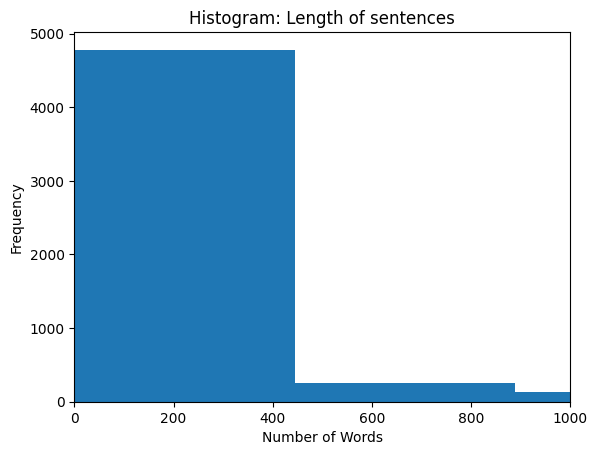

In [ ]:
#Preparing Input Data
import matplotlib.pyplot as plt

# Compute the number of words in each tweet
num = [len(i.split()) for i in text]

# Plot the histogram with a limit on the x-axis
plt.hist(num, bins=30)

plt.title("Histogram: Length of sentences")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")

# Set the x-axis limit to 1000
plt.xlim(0, 1000)  # You can adjust this value based on your actual data range

plt.show()

In [ ]:
# Majority of the clean text  are concentrated around 400 words at most.
# define maximum length of a text
max_len = 300

In [ ]:
# library for progress bar
from tqdm import notebook

# create an empty list to save integer sequence
sent_id = []

# iterate over each feedback
for i in notebook.tqdm(range(len(text))):

  encoded_sent = tokenizer.encode(text[i],
                                  add_special_tokens = True,
                                  max_length = max_len,
                                  truncation = True,
                                  padding = 'max_length')

  # saving integer sequence to a list
  sent_id.append(encoded_sent)

  0%|          | 0/5279 [00:00<?, ?it/s]

In [ ]:
print("Integer Sequence:",sent_id[0])

Integer Sequence: [101, 8285, 5714, 23041, 2063, 4295, 7166, 2272, 9324, 2004, 13097, 2368, 3148, 2514, 2204, 2228, 2689, 2505, 5949, 2051, 2943, 1045, 2635, 5939, 3736, 23736, 2514, 6429, 25353, 27718, 5358, 26489, 6292, 3609, 4432, 1045, 2144, 2467, 2113, 1045, 2113, 2197, 3204, 2095, 5476, 2787, 5959, 4536, 2391, 15366, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# create attention masks
attention_masks = []

# for each sentence...
for sent in sent_id:
  att_mask = [int(token_id > 0) for token_id in sent]

  # store the attention mask for this sentence
  attention_masks.append(att_mask)

In [ ]:
import numpy as np

#Preparing Output
labels = np.array(df['sentiment'])


from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (90% train, 10% validation)
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    sent_id, labels, random_state=2018, test_size=0.1, stratify=labels)

# Split the attention masks in the same way
train_masks, validation_masks, _, _ = train_test_split(
    attention_masks, labels, random_state=2018, test_size=0.1, stratify=labels)


In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

#define a batch size
batch_size = 16

# Create the DataLoader for our training set.
#Dataset wrapping tensors.
train_data = TensorDataset(train_inputs, train_masks, train_labels)

#define a sampler for sampling the data during training
  #random sampler samples randomly from a dataset
  #sequential sampler samples sequentially, always in the same order
train_sampler = RandomSampler(train_data)

#represents a iterator over a dataset. Supports batching, customized data loading order
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
#Dataset wrapping tensors.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)

#define a sequential sampler
#This samples data in a sequential order
validation_sampler = SequentialSampler(validation_data)

#create a iterator over the dataset
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
#create an iterator object
iterator = iter(train_dataloader)

# Load the batch data
sent_id, mask, target = next(iterator)

In [ ]:
sent_id.shape

torch.Size([16, 300])

In [ ]:
sent_id

tensor([[  101, 16697, 13551,  ...,     0,     0,     0],
        [  101,  4067,  2017,  ...,     0,     0,     0],
        [  101,  3081,  4684,  ...,  2147,  3204,   102],
        ...,
        [  101,  1045,  2657,  ...,  5796, 20014,   102],
        [  101,  7632,  1045,  ...,     0,     0,     0],
        [  101,  5254,  1045,  ...,     0,     0,     0]])

In [ ]:
#pass inputs to the model
outputs = bert(sent_id,             #integer sequence
               attention_mask=mask) #attention masks

In [ ]:
# hidden states
hidden_states = outputs[0]

# [CLS] hidden state
CLS_hidden_state = outputs[1]

print("Shape of Hidden States:",hidden_states.shape)
print("Shape of CLS Hidden State:",CLS_hidden_state.shape)

Shape of Hidden States: torch.Size([16, 300, 768])
Shape of CLS Hidden State: torch.Size([16, 768])


In [ ]:
#4. Model Finetuning
# turn off the gradient of all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
import torch.nn as nn

class classifier(nn.Module):

    #define the layers and wrappers used by model
    def __init__(self, bert):

      #constructor
      super(classifier, self).__init__()

      #bert model
      self.bert = bert

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      #dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)

      #dropout layer
      self.dropout = nn.Dropout(0.2)

      #relu activation function
      self.relu =  nn.LeakyReLU()

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

#define the forward pass

    def forward(self, sent_id, mask):

      #pass the inputs to the model
      outputs = self.bert(sent_id, attention_mask=mask)

      # Check the type and content of outputs to understand its structure
      print(type(outputs))
      print(outputs)

      # Access the hidden states based on the structure of outputs
      # For example, if outputs is a tuple and the hidden states are the first element:
      all_hidden_states = outputs.last_hidden_state

      # Extract the first token's hidden state (CLS token)
      cls_hidden_state= all_hidden_states[:, 0]

     #pass CLS hidden state to dense layer
      x = self.fc1(cls_hidden_state)

      #Apply ReLU activation function
      x = self.relu(x)

      #Apply Dropout
      x = self.dropout(x)

      #pass input to the output layer
      x = self.fc2(x)

      #apply softmax activation
      x = self.softmax(x)

      return x


In [ ]:
#create the model
model = classifier(bert)

#push the model to GPU, if available
model = model.to(device)

In [ ]:
#model architecture
model

classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
# push the tensors to GPU
sent_id = sent_id.to(device)
mask = mask.to(device)
target = target.to(device)

# pass inputs to the model
outputs = model(sent_id, mask)

<class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>
BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-2.2391e-01,  2.1971e-01,  6.5904e-02,  ..., -1.5012e-01,
           9.6783e-02,  1.2138e-01],
         [-1.4222e-01,  3.1666e-01, -2.2605e-02,  ..., -2.1713e-01,
          -1.6049e-01,  9.8657e-03],
         [ 8.6462e-03,  1.3960e-01,  2.2869e-01,  ..., -3.7254e-01,
           2.6435e-01, -2.6977e-01],
         ...,
         [-3.3565e-01, -5.0305e-01,  6.0329e-01,  ...,  7.4293e-02,
          -6.7794e-02,  1.9734e-01],
         [-9.9674e-02, -9.4391e-02,  2.0794e-01,  ..., -1.2860e-01,
           2.3371e-01,  1.7619e-01],
         [ 6.4535e-02, -4.8112e-03,  3.6211e-01,  ...,  7.0497e-02,
           1.0885e-01,  1.2460e-01]],

        [[-2.2973e-01,  3.0387e-01,  3.9412e-01,  ..., -3.5555e-01,
           5.0527e-02,  1.2463e-01],
         [ 4.1392e-01,  5.3275e-01,  1.1848e+00,  ..., -1.4039e-01,
           1.3748e-01,  3.5266e-0

In [ ]:
# understand outputs
print(outputs)

tensor([[-1.1262, -1.1553, -1.0195],
        [-1.3713, -0.9481, -1.0252],
        [-1.2439, -1.0604, -1.0067],
        [-1.2744, -1.0041, -1.0384],
        [-1.3092, -1.0532, -0.9646],
        [-1.2578, -1.1593, -0.9113],
        [-1.4535, -1.0280, -0.8952],
        [-1.3746, -0.9759, -0.9937],
        [-1.2696, -1.1008, -0.9508],
        [-1.1823, -1.1310, -0.9923],
        [-1.3763, -1.0299, -0.9405],
        [-1.1990, -1.1463, -0.9658],
        [-1.2960, -1.0313, -0.9947],
        [-1.3382, -1.0543, -0.9435],
        [-1.2784, -1.1132, -0.9339],
        [-1.3531, -1.0433, -0.9435]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)


In [ ]:
# no. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 395,267 trainable parameters


In [ ]:
#Define Optimizer and Loss function
## Import AdamW optimizer
from torch.optim import AdamW

# Create the AdamW optimizer
optimizer = AdamW(model.parameters(), lr=3e-5,weight_decay=0.03)


Text(0.5, 1.0, 'Class Distribution')

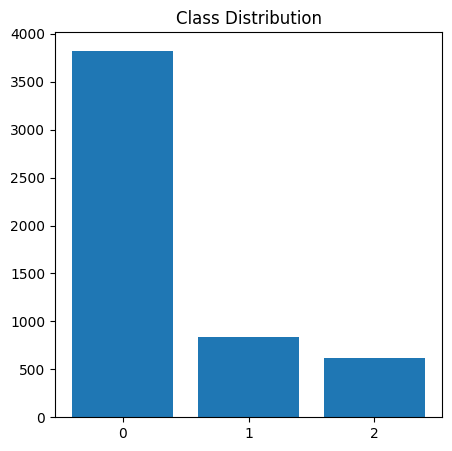

In [ ]:
# understand the class distribution
keys=['0','1','2']

# set figure size
plt.figure(figsize=(5,5))

# plot bat chart
plt.bar(keys,class_counts)

# set title
plt.title('Class Distribution')

In [ ]:
#library for array processing
import numpy as np

#library for computing class weights
from sklearn.utils.class_weight import compute_class_weight

# Update to use the new API
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)


print("Class Weights:",class_weights)

Class Weights: [2.85197191 2.10234966 0.46004357]


In [ ]:
# converting a list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# transfer to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

In [ ]:
#compute the loss
loss = cross_entropy(outputs, target)
print("Loss:",loss)

Loss: tensor(1.0691, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
import time
import datetime

# compute time in hh:mm:ss
def format_time(elapsed):
    # round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # format as hh:mm:ss
    return str(datetime.timedelta(seconds = elapsed_rounded))

In [ ]:
#define a function for training the model
def train():

  print("\nTraining.....")

  #set the model on training phase - Dropout layers are activated
  model.train()

  #record the current time
  t0 = time.time()

  #initialize loss and accuracy to 0
  total_loss, total_accuracy = 0, 0

  #Create a empty list to save the model predictions
  total_preds=[]

  #for every batch
  for step,batch in enumerate(train_dataloader):

    # Progress update after every 40 batches.
    if step % 40 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    #push the batch to gpu
    batch = tuple(t.to(device) for t in batch)

    #unpack the batch into separate variables
    # `batch` contains three pytorch tensors:
    #   [0]: input ids
    #   [1]: attention masks
    #   [2]: labels
    sent_id, mask, labels = batch

    # Always clear any previously calculated gradients before performing a
    # backward pass. PyTorch doesn't do this automatically.
    model.zero_grad()

    # Perform a forward pass. This returns the model predictions
    preds = model(sent_id, mask)

    #compute the loss between actual and predicted values
    loss =  cross_entropy(preds, labels)

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value
    # from the tensor.
    total_loss = total_loss + loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    #The model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    #Accumulate the model predictions of each batch
    total_preds.append(preds)

  #compute the training loss of a epoch
  avg_loss     = total_loss / len(train_dataloader)

  #The predictions are in the form of (no. of batches, size of batch, no. of classes).
  #So, reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
#define a function for evaluating the model
def evaluate():

  print("\nEvaluating.....")

  #set the model on training phase - Dropout layers are deactivated
  model.eval()

  #record the current time
  t0 = time.time()

  #initialize the loss and accuracy to 0
  total_loss, total_accuracy = 0, 0

  #Create a empty list to save the model predictions
  total_preds = []

  #for each batch
  for step,batch in enumerate(validation_dataloader):

    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(validation_dataloader), elapsed))

    #push the batch to gpu
    batch = tuple(t.to(device) for t in batch)

    #unpack the batch into separate variables
    # `batch` contains three pytorch tensors:
    #   [0]: input ids
    #   [1]: attention masks
    #   [2]: labels
    sent_id, mask, labels = batch

    #deactivates autograd
    with torch.no_grad():

      # Perform a forward pass. This returns the model predictions
      preds = model(sent_id, mask)

      # Check if preds is a tuple and extract the correct element
      if isinstance(preds, tuple):
        preds = preds[0]

      #compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      # Accumulate the validation loss over all of the batches so that we can
      # calculate the average loss at the end. `loss` is a Tensor containing a
      # single value; the `.item()` function just returns the Python value
      # from the tensor.
      total_loss = total_loss + loss.item()

      #The model predictions are stored on GPU. So, push it to CPU
      preds=preds.detach().cpu().numpy()

      #Accumulate the model predictions of each batch
      total_preds.append(preds)

  #compute the validation loss of a epoch
  avg_loss = total_loss / len(validation_dataloader)

  #The predictions are in the form of (no. of batches, size of batch, no. of classes).
  #So, reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:

#Train the Model

#Assign the initial loss to infinite
best_valid_loss = float('inf')

#create a empty list to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

epochs = 3

#for each epoch
for epoch in range(epochs):

    print('\n....... epoch {:} / {:} .......'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    #accumulate training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

print("")
print("Training complete!")


....... epoch 1 / 3 .......

Training.....
  Batch    40  of    297.    Elapsed: 0:00:30.
  Batch    80  of    297.    Elapsed: 0:01:00.
  Batch   120  of    297.    Elapsed: 0:01:30.
  Batch   160  of    297.    Elapsed: 0:02:01.
  Batch   200  of    297.    Elapsed: 0:02:32.
  Batch   240  of    297.    Elapsed: 0:03:04.
  Batch   280  of    297.    Elapsed: 0:03:36.

Evaluating.....

Training Loss: 0.826
Validation Loss: 1.039

....... epoch 2 / 3 .......

Training.....
  Batch    40  of    297.    Elapsed: 0:00:31.
  Batch    80  of    297.    Elapsed: 0:01:03.
  Batch   120  of    297.    Elapsed: 0:01:35.
  Batch   160  of    297.    Elapsed: 0:02:07.
  Batch   200  of    297.    Elapsed: 0:02:38.
  Batch   240  of    297.    Elapsed: 0:03:10.
  Batch   280  of    297.    Elapsed: 0:03:42.

Evaluating.....

Training Loss: 0.647
Validation Loss: 1.069

....... epoch 3 / 3 .......

Training.....
  Batch    40  of    297.    Elapsed: 0:00:32.
  Batch    80  of    297.    Elapsed: 0

In [ ]:
#load weights of the best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<ipython-input-93-d5e1bb6310d2>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [ ]:
# get the model predictions on the validation data
# returns 2 elements- Validation loss and Predictions
valid_loss, preds = evaluate()
print(valid_loss)


Evaluating.....
1.039048896594481


In [ ]:
# Converting the log(probabities) into a classes
# Choosing index of a maximum value as class
y_pred = np.argmax(preds,axis=1)
# actual labels
y_true = validation_labels

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.24      0.52      0.33        62
           1       0.37      0.30      0.33        84
           2       0.79      0.68      0.73       382

    accuracy                           0.60       528
   macro avg       0.47      0.50      0.47       528
weighted avg       0.66      0.60      0.62       528



In [ ]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(y_true, y_pred, average='macro').round(3)
print(f"Macro F1-Score: {macro_f1}")

Macro F1-Score: 0.465


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer, BertConfig

class Classifier(nn.Module):
    def __init__(self, bert_model):
        super(Classifier, self).__init__()
        self.bert = bert_model
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 3)  # Adjust the output size based on your number of classes
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.LeakyReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        outputs = self.bert(sent_id, attention_mask=mask)
        all_hidden_states = outputs.last_hidden_state
        cls_hidden_state = all_hidden_states[:, 0]
        x = self.fc1(cls_hidden_state)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Initialize BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize the classifier with the BERT model
model = Classifier(bert_model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Load the saved weights
model_path = 'saved_weights.pt'
model.load_state_dict(torch.load(model_path))
model.to(device)

import pandas as pd
from torch.utils.data import DataLoader, Dataset

class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

def preprocessor(text):
    # Preprocessing function implementation

    # Expand contractions
    text = contractions.fix(text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Replace numbers
    text = re.sub(r'\d+', '<num>', text)

    # Replace emails and mentions
    text = re.sub(r'\S+@\S+', '<email>', text)  # replace emails with <email>
    text = re.sub(r'@\w+', '<mention>', text)   # replace mentions with <mention>

    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Removes emojis and certain symbols
    text = re.sub(r'[^\w\s,]', '', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Replace numbers with a placeholder
    text = re.sub(r'\d+', '<num>', text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', " ".join(tokens)).strip()

    return text
    pass

# Load and preprocess the test data
test_df = pd.read_csv('test.csv')
test_df['preprocessed_text'] = test_df['text'].apply(preprocessor)

# Create DataLoader for the test set
test_dataset = TestDataset(test_df['preprocessed_text'].tolist(), tokenizer, max_length=250)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

import numpy as np

def evaluate_test(model, dataloader, device):
    print("\nEvaluating.....")
    model.eval()
    total_preds = []

    for batch in dataloader:
        batch = {key: value.to(device) for key, value in batch.items()}

        with torch.no_grad():
            outputs = model(batch['input_ids'], batch['attention_mask'])
            logits = outputs
            preds = logits.detach().cpu().numpy()
            total_preds.append(preds)

    total_preds = np.concatenate(total_preds, axis=0)
    return total_preds

# Get predictions
predictions = evaluate_test(model, test_dataloader, device)

# Add predictions to the dataframe
test_df['sentiment'] = np.argmax(predictions, axis=1)

# Rename and drop columns
test_df.rename(columns={'unique_hash':'id'}, inplace=True)
test_df = test_df[['id', 'sentiment']]

# Save results to a new CSV file
test_df.to_csv('test_predictions.csv', index=False)

# Print the first few rows of the result
print(test_df.head())


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-99-524fa3d97f9e>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle


Evaluating.....
                                         id  sentiment
0  9e9a8166b84114aca147bf409f6f956635034c08          2
1  e747e6822c867571afe7b907b51f0f2ca67b0e1a          0
2  50b6d851bcff4f35afe354937949e9948975adf7          2
3  7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae          2
4  8b37d169dee5bdae27060949242fb54feb6a7f7f          2
